In [38]:
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
START = "2010-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

# Define a function to load the dataset
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data
data = load_data('TCS.NS')
df=data
df = df.drop(['Date', 'Adj Close'], axis = 1)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
0,377.399994,379.450012,374.524994,375.825012,1963682
1,377.500000,379.774994,373.274994,375.924988,2014488
2,375.924988,376.100006,366.500000,367.424988,3349176
3,367.750000,369.700012,355.500000,357.200012,6474892
4,358.000000,359.250000,348.250000,349.899994,6048178


Text(0.5, 1.0, 'Comparision Of 100 Days And 200 Days Moving Averages')

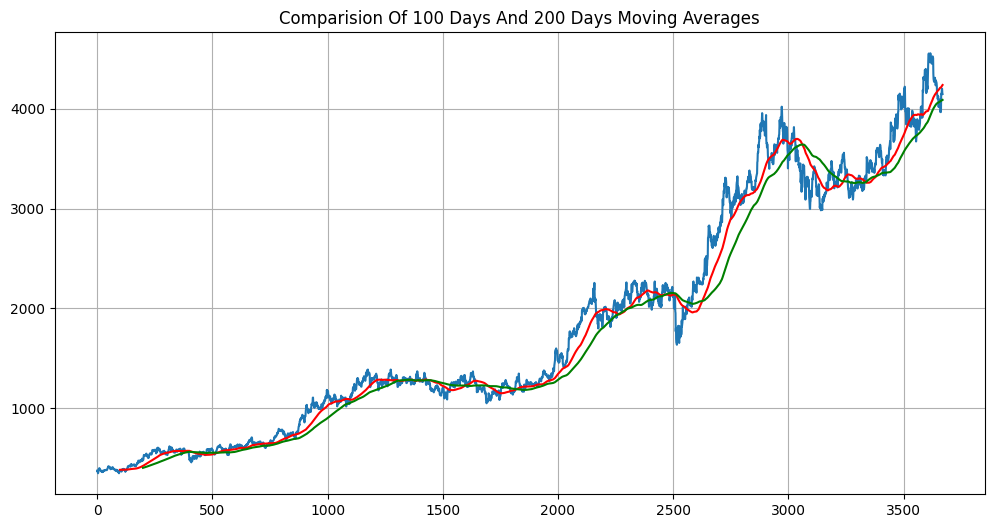

In [29]:
ma100 = df.Close.rolling(100).mean()
ma200 = df.Close.rolling(200).mean()

plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.grid(True)
plt.title('Comparision Of 100 Days And 200 Days Moving Averages')

In [ ]:
# Splitting data into training and testing

train = pd.DataFrame(data[0:int(len(data)*0.70)])
test = pd.DataFrame(data[int(len(data)*0.70): int(len(data))])

print(train.shape)
print(test.shape)
test.head()

(2569, 7)
(1101, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
2569,2020-06-10,2077.050049,2132.000000,2073.500000,2108.750000,1985.281860,5168397
2570,2020-06-11,2100.000000,2105.000000,2061.800049,2067.649902,1946.588257,2269513
2571,2020-06-12,2011.199951,2049.199951,2011.000000,2039.500000,1920.086792,2842642
2572,2020-06-15,2039.099976,2059.000000,2000.949951,2029.900024,1911.048828,2399022
2573,2020-06-16,2065.000000,2073.949951,2031.000000,2045.800049,1926.017822,2146528


In [35]:
scaler = MinMaxScaler(feature_range=(0,1))
train_close = train.iloc[:, 4:5].values
test_close = test.iloc[:, 4:5].values
data_training_array = scaler.fit_transform(train_close)
data_training_array

x_train = []
y_train = [] 

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train) 

In [37]:
model = Sequential()
# Layer 1
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True
              ,input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Layer 2
model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))

# Layer 3
model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))

# Layer 4
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

# Layer Dense
model.add(Dense(units = 1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_5 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_6 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_7 (LSTM)               (None, 120)              

In [39]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train,epochs = 100)
model.save('keras_model.h5')

Epoch 1/100
63/78 [=======================>......] - ETA: 4s - loss: 0.0460 - mean_absolute_error: 0.1433

KeyboardInterrupt: 

In [ ]:
past_100_days = pd.DataFrame(train_close[-100:])
test_df = pd.DataFrame(test_close)
#Defining the final dataset for 
# testing by including last 100 coloums of the training 
# dataset to get the prediction from the 1st column of the testing dataset.
final_df = past_100_days.append(test_df, ignore_index = True)
input_data = scaler.fit_transform(final_df)
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
   x_test.append(input_data[i-100: i])
   y_test.append(input_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

# Making predictions

y_pred = model.predict(x_test)

In [ ]:
scale_factor = 1/0.00041967
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#eval
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
mae_percentage = (mae / np.mean(y_test)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

from sklearn.metrics import r2_score

# Actual values
actual = y_test

# Predicted values
predicted = y_pred

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

# Plotting the R2 score
fig, ax = plt.subplots()
ax.barh(0, r2, color='skyblue')
ax.set_xlim([-1, 1])
ax.set_yticks([])
ax.set_xlabel('R2 Score')
ax.set_title('R2 Score')

# Adding the R2 score value on the bar
ax.text(r2, 0, f'{r2:.2f}', va='center', color='black')

plt.show()

plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()

Different code

,Close,Open,High,Low,Volume,Change %,SMA,RSI,ATR
Date,,,,,,,,,
1980-12-30,0.16,0.16,0.16,0.16,68.88M,0.00%,0.136364,80.259386,0.005347
1980-12-31,0.15,0.15,0.15,0.15,35.75M,-6.25%,0.139091,63.285998,0.006135
1981-01-02,0.15,0.15,0.16,0.15,21.66M,0.00%,0.142727,63.285998,0.006774
1981-01-05,0.15,0.15,0.15,0.15,35.73M,0.00%,0.145455,63.285998,0.005679
1981-01-06,0.14,0.14,0.14,0.14,45.16M,-6.67%,0.147273,49.385004,0.006365


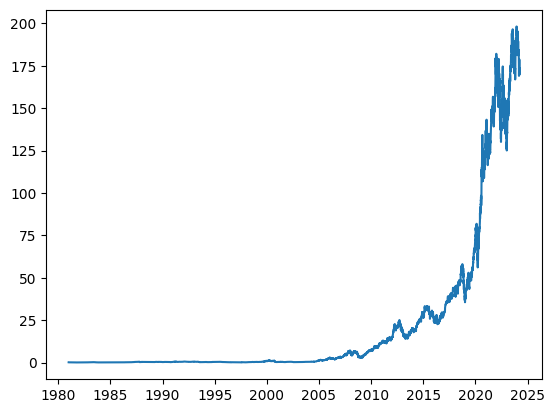

In [20]:
df = pd.read_csv("appl_data.csv")
df = df.rename(columns={'Price': 'Close', 'Vol.': 'Volume'})
df=df[df['Volume']!=0]
df = df.iloc[::-1].reset_index(drop=True)

def str_to_datetime(s): 
  split = s.split('/')
  month, day, year  = int(split[0]), int(split[1]), int(split[2])
  return dt.datetime(year=year, month=month, day=day)

'''
def is_outlier(s):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR    
    return (s < lower_bound) | (s > upper_bound)

# Identify outliers in any of the specified columns
outliers_mask = is_outlier(df['Close']) | is_outlier(df['Open']) | is_outlier(df['Low'])
'''

df['Date'] = df['Date'].apply(str_to_datetime) 
df['Date']

df.index = df.pop('Date')

df['SMA'] = ta.sma(df['Close'], length=11)
df['RSI'] = ta.rsi(df['Close'], length=11)
df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=7)
df = df.dropna()

plt.plot(df.index, df['Close'])
df.head()

In [90]:
X = df.drop(columns='Close/Last', axis=1)
Y = df['Close/Last'].values.reshape(-1, 1)
# Standardize data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(X)
X = standardized_data
# Scale the target variable
#standardized_data = scaler.fit_transform(Y)
#Y = standardized_data

In [102]:
train_size = int(len(Y) * 0.8)  # 80% for training
X_train = X[:train_size]
Y_train = Y[:train_size]
X_test = X[train_size:]
Y_test = Y[train_size:]

In [103]:
# Create sequences for LSTM
def create_dataset(data_X, data_Y, time_step=1):
    Xs, ys = [], []
    for i in range(len(data_X) - time_step - 1):
        Xs.append(data_X[i:(i + time_step)])
        ys.append(data_Y[i + time_step])
    return np.array(Xs), np.array(ys)

In [104]:
time_step = 10
X_train_seq, Y_train_seq = create_dataset(X_train, Y_train, time_step)
X_test_seq, Y_test_seq = create_dataset(X_test, Y_test, time_step)

# Reshape input to be [samples, time steps, features]
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2])
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2])

In [109]:
# LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<bound method Model.summary of <Sequential name=sequential_2, built=True>>

In [110]:
model.fit(X_train_seq, Y_train_seq, epochs=200, batch_size=32, verbose=1, shuffle=False)

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 34959.9297
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4680358.5000
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18570.4629
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1505388.0000
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 15603.9551
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 14903.0312
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 14550.9717
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 14430.7676
Epoch 9/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 10573.9990
Epoch 10/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1635795.7500
Epoch 11/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 25256.8086
Epoch 12/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8546.4707
Epoch 13/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4326.7437
Epoch 14/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3718.656

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


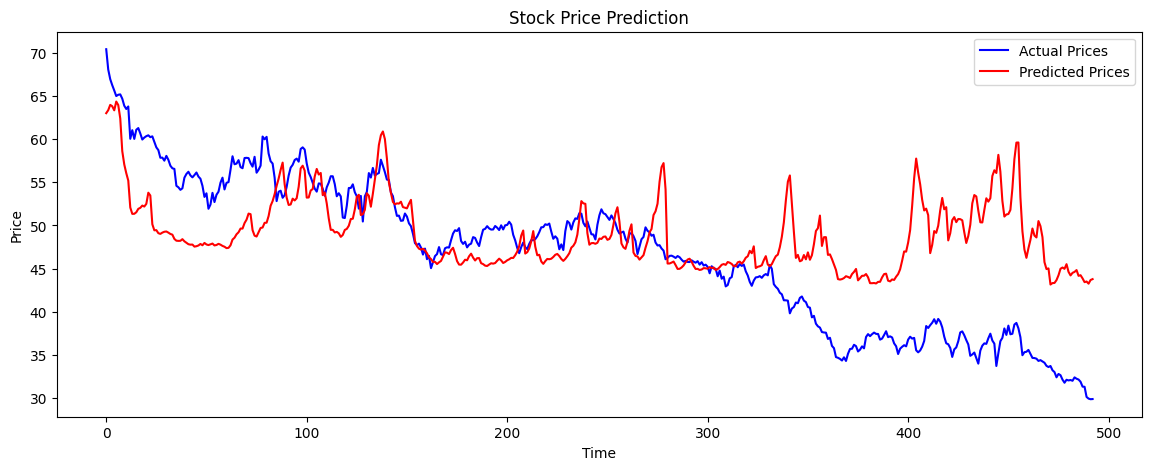

In [111]:
# Make predictions
predictions = model.predict(X_test_seq)

# Prepare the actual values for plotting
Y_test_actual = Y[train_size + time_step + 1:]

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(Y_test_actual, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()